In [54]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from pydil.ot_utils.pot_utils import emd

In [55]:
for it in range(1, 11):
    # Parameters
    num_samples = 1000
    n_classes = 10
    n_dim = 3
    n_dim_high = 100

    # Generate random means and covariances for each component
    means = np.random.randn(n_classes, n_dim) * 10
    covariances = []
    for _ in range(n_classes):
        rand_matrix = np.random.rand(n_dim, n_dim)
        covariances.append(rand_matrix @ rand_matrix.T + 0.1 * np.eye(n_dim))

    # Normalize weights to sum to 1
    weights = np.random.rand(n_classes)
    weights /= np.sum(weights)

    n_samples_comp = np.random.multinomial(num_samples, np.array(weights))

    while 0 in n_samples_comp:
        weights = np.random.rand(n_classes)
        weights /= np.sum(weights)
        n_samples_comp = np.random.multinomial(num_samples, np.array(weights))

    def non_linear_array(x):
        vec = np.array([x[0], x[1], x[2], x[0]*x[1], x[0]*x[2], x[1]*x[2]])
        return vec

    data_list = []
    for k, (mean, covariance, sample) in enumerate(zip(means, covariances, n_samples_comp)):
        array_3d = np.random.multivariate_normal(mean, covariance, int(sample))
        array_non_linear = np.zeros((int(sample), 6)) # 6 car non linéarité (x, y, z, xy, xz, yz) 
        for i in range(int(sample)):
            array_non_linear[i] = non_linear_array(array_3d[i])
        features = np.dot(array_non_linear, np.random.rand(6, n_dim_high))
        classes = k * np.ones(int(sample))
        data_list.append(np.concatenate([features, classes.reshape(-1, 1)], axis=1))

    data = np.vstack(data_list)
    data_feat = data[:, :-1]
    data_class = data[:, -1]

    def generate_random_spd_matrix(n):
        A = np.random.randn(n, n)
        spd_matrix = np.dot(A, A.T)  # Ensure the matrix is symmetric
        spd_matrix += np.eye(n) * 0.1  # Add a small multiple of the identity matrix for positive definiteness
        spectral_radius = np.max(np.abs(np.linalg.eigvals(spd_matrix)))
        if spectral_radius > 2:
            spd_matrix /= (spectral_radius/2)
        return spd_matrix

    def affine_transformation(data_feat):
        product_matrix = generate_random_spd_matrix(n_dim_high)
        sum_vector = np.random.randn(1, n_dim_high)
        new_data_feat = np.dot(data_feat, product_matrix) + sum_vector
        return new_data_feat

    domains = [data]
    for i in range(5):
        new_data_feat = affine_transformation(data_feat)
        for c in range(n_classes):
            ind_c = np.where(data_class == c)[0]
            t_c = np.random.rand()
            new_data_feat[ind_c] = t_c * new_data_feat[ind_c]
        new_data = np.concatenate((new_data_feat, data_class.reshape(-1, 1)), axis=1)
        domains.append(new_data)

    toy_dataset = np.concatenate((domains[0], np.zeros((domains[0].shape[0], 1))), axis=1)

    for i in range(1, len(domains)):
        data_to_concatenate = np.concatenate((domains[i], i * np.ones((domains[0].shape[0], 1))), axis=1)
        toy_dataset = np.concatenate((toy_dataset, data_to_concatenate), axis=0)

    np.save(f'data2/toy_non_linear_100d_dataset_{it}.npy', toy_dataset)

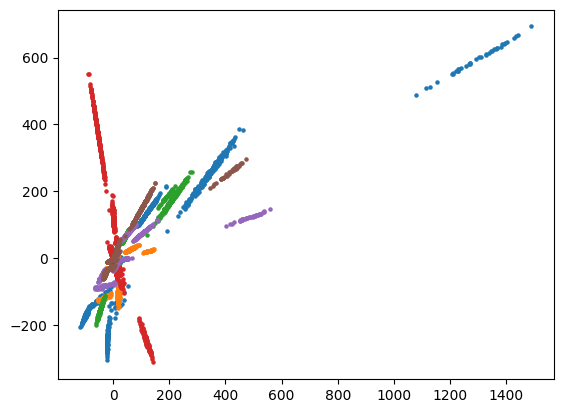

In [48]:
fig, ax = plt.subplots()
for i in range(len(domains)):
    ax.scatter(domains[i][:, 0], domains[i][:, 1], s = 5)

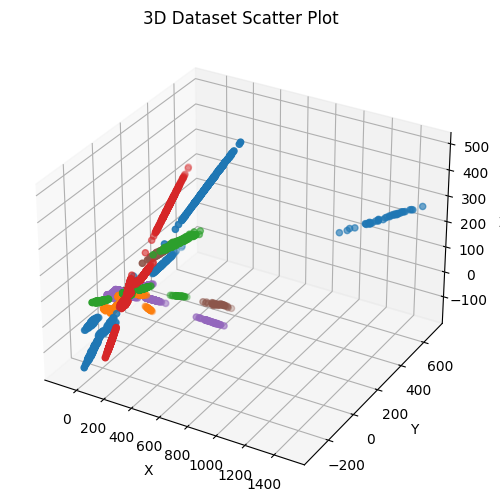

In [49]:
# Create a 3D scatter plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of the 3D dataset
for i in range(len(domains)):
    ax.scatter(domains[i][:, 0], domains[i][:, 1], domains[i][:, 2])

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set title
ax.set_title('3D Dataset Scatter Plot')

plt.show()

In [51]:
import os
import pickle
target = 'C'
with open(os.path.join('data', 'mlp_fts_256_target_{}.pkl'.format(target)), 'rb') as f:
        dataset = pickle.loads(f.read())

Xs, ys = [], []
d = None
keys = list(dataset.keys())
for i in [0, 1]:
    features = dataset[keys[i]]['Features']
    labels = dataset[keys[i]]['Labels'].argmax(dim=1)
    domain = i*np.ones((features.shape[0], 1))
    Xs.append(features.float())
    ys.append(labels.float())
    if d is None:
        d = domain
    else:
        d = np.concatenate([d, domain], axis=0)

Xt = dataset[target]['fold 0']['Train']['Features'].float()
yt = dataset[target]['fold 0']['Train']['Labels'].float().argmax(dim=1)

Xt_test = dataset[target]['fold 0']['Test']['Features'].float()
yt_test = dataset[target]['fold 0']['Test']['Labels'].float().argmax(dim=1)
d = np.concatenate([d, 2*np.ones((Xt.shape[0], 1))], axis=0)

n_domains = int(np.max(d)) + 1
n_features = Xt.shape[1]
n_classes = int(np.max(yt.numpy())) + 1

In [52]:
import skdim
import numpy as np

#estimate global intrinsic dimension
#danco = skdim.id.DANCo().fit(Xt_test.numpy())
#estimate local intrinsic dimension (dimension in k-nearest-neighborhoods around each point):
lpca = skdim.id.lPCA().fit_pw(Xt.numpy(),
                              n_neighbors = 100,
                              n_jobs = 1)

#get estimated intrinsic dimension
#print(danco.dimension_)

In [53]:
np.mean(lpca.dimension_pw_)

12.978571428571428